In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from ToyTrajectoryNet.losses import MMD_loss, OT_loss, Density_loss, Local_density_loss
from ToyTrajectoryNet.utils import group_extract, sample, to_np, generate_steps
from ToyTrajectoryNet.models import ToyModel, make_model, Autoencoder, ToySDEModel
from ToyTrajectoryNet.plots import plot_comparision, plot_losses
from ToyTrajectoryNet.train import train, train_ae
from ToyTrajectoryNet.constants import ROOT_DIR, DATA_DIR, NTBK_DIR, IMGS_DIR, RES_DIR
from ToyTrajectoryNet.datasets import (
    make_diamonds, make_swiss_roll, make_tree, make_eb_data, 
    make_dyngen_data, relabel_data
)
from ToyTrajectoryNet.ode import NeuralODE, ODEF
from ToyTrajectoryNet.geo import DiffusionDistance, old_DiffusionDistance
from ToyTrajectoryNet.exp import setup_exp
from ToyTrajectoryNet.eval import generate_plot_data

import os, pandas as pd, numpy as np, \
    seaborn as sns, matplotlib as mpl, matplotlib.pyplot as plt, \
    torch, torch.nn as nn
import random

from tqdm.notebook import tqdm
from phate import PHATE

# for geodesic learning
from sklearn.gaussian_process.kernels import RBF
from sklearn.manifold import MDS

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Run Petals Dataset


## Load dataset

In [2]:
phate_dims = None
round_labels=None
use_gaussian=None
add_noise_directly=None
add_noise_after_phate=None
scale_factor=None

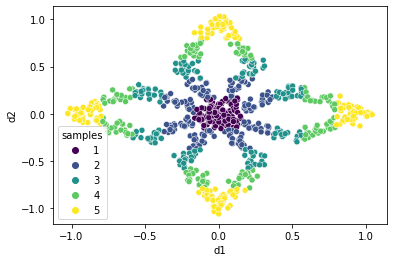

In [3]:
df = make_diamonds()
sns.scatterplot(data=df, x='d1', y='d2', hue='samples', palette='viridis');

## Train autoencoder or the geodesic embedding

In [4]:
from sklearn.gaussian_process.kernels import RBF
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

use_cuda = torch.cuda.is_available()
groups = sorted(df.samples.unique())

model_features = len(df.columns) - 1
encoder_layers = [model_features,8,8]

dae = Autoencoder(
    encoder_layers = encoder_layers,
    decoder_layers = [32,8,model_features],
    activation='ReLU'
)
optimizer = torch.optim.AdamW(dae.parameters())
dae.cuda() if use_cuda else None

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=2, bias=True)
  )
)

dist=None and recon=True for DAE or dist=DiffusionDistance(knn=40,t_max=3) recon=False for geo embedding

In [8]:
old_DiffusionDistance(RBF(5.0),t_max=3),DiffusionDistance(knn=40,t_max=3,symmetrize=True)

(<ToyTrajectoryNet.geo.old_DiffusionDistance at 0x7f6557a016a0>,
 <ToyTrajectoryNet.geo.DiffusionDistance at 0x7f6552ecaf40>)

In [9]:
import time
start_time_geo = time.time()
losses = train_ae(
        dae, df, groups, optimizer, n_epochs=1000, sample_size=(30,),
    noise_min_scale=0.001, noise_max_scale=0.02, dist=old_DiffusionDistance(RBF(0.5),t_max=5), recon=False
)
run_time_geo = time.time() - start_time_geo
print(run_time_geo)

  0%|          | 0/1000 [00:00<?, ?it/s]

Train loss dist: 0.1156
Train loss dist: 0.07046
Train loss dist: 0.05038
Train loss dist: 0.03669
Train loss dist: 0.02778
Train loss dist: 0.0269
Train loss dist: 0.02179
Train loss dist: 0.01972
Train loss dist: 0.0209
Train loss dist: 0.01658
Train loss dist: 0.01783
Train loss dist: 0.01869
Train loss dist: 0.01915
Train loss dist: 0.01442
Train loss dist: 0.0142
Train loss dist: 0.01528
Train loss dist: 0.01506
Train loss dist: 0.01534
Train loss dist: 0.01254
Train loss dist: 0.01371
31.005483865737915


## Or load a DF

In [52]:
import pickle
load = False
if load:
    with open(os.path.expanduser('~/Downloads/dyngen-df.pkl'), 'rb') as f:
        df = pickle.load(f)

In [53]:
df

,samples,d1,d2,d3,d4,d5
0,1.0,-1.628050,-0.430427,-1.151090,-0.246302,-0.209818
2,1.0,-1.584497,-0.627169,-1.037722,-0.159881,-0.039044
4,2.0,-1.260485,-0.956927,-1.159263,-0.119324,-0.024126
5,1.0,-1.615244,-0.896255,-0.891685,-0.179515,-0.051142
6,5.0,2.067759,3.714734,-0.171271,-0.391205,0.039743
...,...,...,...,...,...,...
987,5.0,2.692012,-2.100317,0.290197,0.066297,0.047441
988,2.0,-0.852765,1.584621,-1.731889,-0.408121,0.180328
991,2.0,-0.820417,-1.675615,-1.008027,-0.297358,-0.076532
992,2.0,-0.535870,-1.877094,-1.024392,-0.336143,-0.094988


## Specify parameters

Note: if we trained geo and reconstruction at the same time, then we use geo even if 'geo_emb=None'

In [66]:
torch.manual_seed(10)
random.seed(10)
np.random.seed(10)

exp_name = 'sde_petals'

use_geo = False
use_dae = False
use_density_loss = False

lambda_density = 20
top_k=5
hinge_value = 0.01

small_model = True
use_cuda = torch.cuda.is_available()

emb_features = encoder_layers[-1] if use_dae else len(df.columns) - 1
groups = sorted(df.samples.unique())

layers_small = [16,32,16]
activation = 'LeakyReLU'
ode_method = 'euler'#'rk4'
n_aug=2
sde_scales=None
#sde_scales = len(groups)*[0.2] # if use dopri5 or any adaptative solver, one needs to increase the number of scales, e.g. (len(groups)+10)*[0.2]

if use_geo:
    geoemb = dae.encoder
    if use_cuda:
        geoemb = geoemb.cuda()
else:
    geoemb=None
if use_dae:
    autoencoder = dae
    if use_cuda:
        autoencoder = autoencoder.cuda()
else:
    autoencoder=None
    
if not small_model:
    model = make_model(emb_features, [32, 64, 128, 64, 32], activation=activation, which='sde')
else:
    model = make_model(
        emb_features, layers_small, 
        which='sde',
        activation=activation, method=ode_method, 
        rtol=0.001,atol=0.001, scales=sde_scales, n_aug=n_aug
    )
if use_cuda:
    model.to(torch.device('cuda'))
    model = model.cuda()

In [67]:
print(model)

ToySDEModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=5, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)


In [68]:
groups = sorted(df.samples.unique())
steps = generate_steps(groups)

sample_with_replacement = False
sample_size=(60, )
n_samples=1

n_local_epochs = 20
n_epochs = 0
n_post_local_epochs = 0

n_batches = 20

optimizer = torch.optim.AdamW(model.parameters())

criterion_name = 'ot'
if criterion_name == 'mmd':
    criterion = MMD_loss()
else:
    criterion = OT_loss()

hold_one_out = False
hold_out = 'random' #'random' or time 

local_losses = {f'{t0}:{t1}':[] for (t0, t1) in steps}
batch_losses = []
globe_losses = []


use_local_density = False


n_points = 100
n_trajectories = 100
n_bins = 100

add_noise = False
noise_scale = 0.09
use_gaussian = False

In [69]:
opts = {
    'phate_dims': phate_dims,
    'round_labels': round_labels,
    'use_gaussian': use_gaussian,
    'add_noise_directly': add_noise_directly,
    'add_noise_after_phate': add_noise_after_phate,
    'scale_factor': scale_factor,
    'use_cuda': use_cuda,
    'emb_features': emb_features,
    'model_features': model_features,
    'small_model': small_model,
    'exp_name': exp_name,
    'groups': groups,
    'steps': steps,
    'sample_with_replacement': sample_with_replacement,
    'sample_size': sample_size,
    'use_geo': use_geo,
    'n_local_epochs': n_local_epochs,
    'n_epochs': n_epochs,
    'n_post_local_epochs': n_post_local_epochs,
    'n_batches': n_batches,
    'criterion_name': criterion_name,
    'hold_one_out': hold_one_out,
    'hold_out': hold_out,
    'hinge_value': hinge_value,
    'use_density_loss': use_density_loss,
    'use_local_density': use_local_density,
    'n_points': n_points,
    'n_trajectories': n_trajectories,
    'n_bins': n_bins,
    'add_noise': add_noise,
    'noise_scale': noise_scale,
    'use_gaussian': use_gaussian,
    'autoencoder': autoencoder,
    'n_samples': n_samples,
    'activation': activation,
    'layer': layers_small,
    'ode_solver': ode_method,
    'lambda_density':lambda_density,
    'top_k':top_k,
    'use_dae': use_dae,
    'sde_scales': sde_scales,
    'n_augmented_ode': n_aug
}

In [70]:
exp_dir, logger = setup_exp(RES_DIR, opts, exp_name) 

In [71]:
import time
start_time = time.time()
for epoch in tqdm(range(n_local_epochs), desc='Pretraining Epoch'):
    l_loss, b_loss, g_loss = train(
        model, df, groups, optimizer, n_batches, 
        criterion = criterion, use_cuda = use_cuda,
        local_loss=True, global_loss=False, apply_losses_in_time=True,
        hold_one_out=hold_one_out, hold_out=hold_out, 
        hinge_value=hinge_value,
        use_density_loss = use_density_loss, use_local_density = use_local_density,       
        top_k = top_k, lambda_density = lambda_density,  lambda_density_local = 1.0, 
        geo_emb = geoemb, use_emb = use_geo, sample_size=sample_size, 
        sample_with_replacement=sample_with_replacement, logger=logger, autoencoder=autoencoder, n_samples=n_samples,
        add_noise=add_noise, noise_scale=noise_scale, use_gaussian=use_gaussian
    )
    for k, v in l_loss.items():  
        local_losses[k].extend(v)
    batch_losses.extend(b_loss)
    globe_losses.extend(g_loss)
    
for epoch in tqdm(range(n_epochs), desc='Epoch'):
    l_loss, b_loss, g_loss = train(
        model, df, groups, optimizer, n_batches, 
        criterion = criterion, use_cuda = use_cuda,
        local_loss=False, global_loss=True, apply_losses_in_time=True,
        hold_one_out=hold_one_out, hold_out=hold_out, 
        hinge_value=hinge_value,
        use_density_loss = use_density_loss, use_local_density = use_local_density,       
        top_k = top_k, lambda_density = lambda_density, lambda_density_local = 1.0, 
        geo_emb =  geoemb, use_emb = use_geo, sample_size=sample_size, 
        sample_with_replacement=sample_with_replacement, logger=logger, autoencoder=autoencoder, n_samples=n_samples,
        add_noise=add_noise, noise_scale=noise_scale, use_gaussian=use_gaussian
    )

    for k, v in l_loss.items():  
        local_losses[k].extend(v)
    batch_losses.extend(b_loss)
    globe_losses.extend(g_loss)
    
for epoch in tqdm(range(n_post_local_epochs), desc='Posttraining Epoch'):
    l_loss, b_loss, g_loss = train(
        model, df, groups, optimizer, n_batches, 
        criterion = criterion, use_cuda = use_cuda,
        local_loss=True, global_loss=False, apply_losses_in_time=True,
        hold_one_out=hold_one_out, hold_out=hold_out, 
        hinge_value=hinge_value,
        use_density_loss = use_density_loss, use_local_density = use_local_density,       
        top_k = top_k, lambda_density = lambda_density,  lambda_density_local = 1.0, 
        geo_emb =  geoemb, use_emb = use_geo, sample_size=sample_size, 
        sample_with_replacement=sample_with_replacement, logger=logger, autoencoder=autoencoder, n_samples=n_samples,
        add_noise=add_noise, noise_scale=noise_scale, use_gaussian=use_gaussian
    )
    for k, v in l_loss.items():  
        local_losses[k].extend(v)
    batch_losses.extend(b_loss)
    globe_losses.extend(g_loss)
run_time = time.time() - start_time + run_time_geo if use_geo else time.time() - start_time
print(run_time)

Pretraining Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

/home/solstice/Projects/ToyTrajectoryNet/ToyTrajectoryNet/losses.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pi = torch.tensor(pi)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0it [00:00, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

2852.7776951789856


In [72]:
# 465.36s/it * 10 iterations ~ 70 minutes
# try on dyngen once
# nn for g

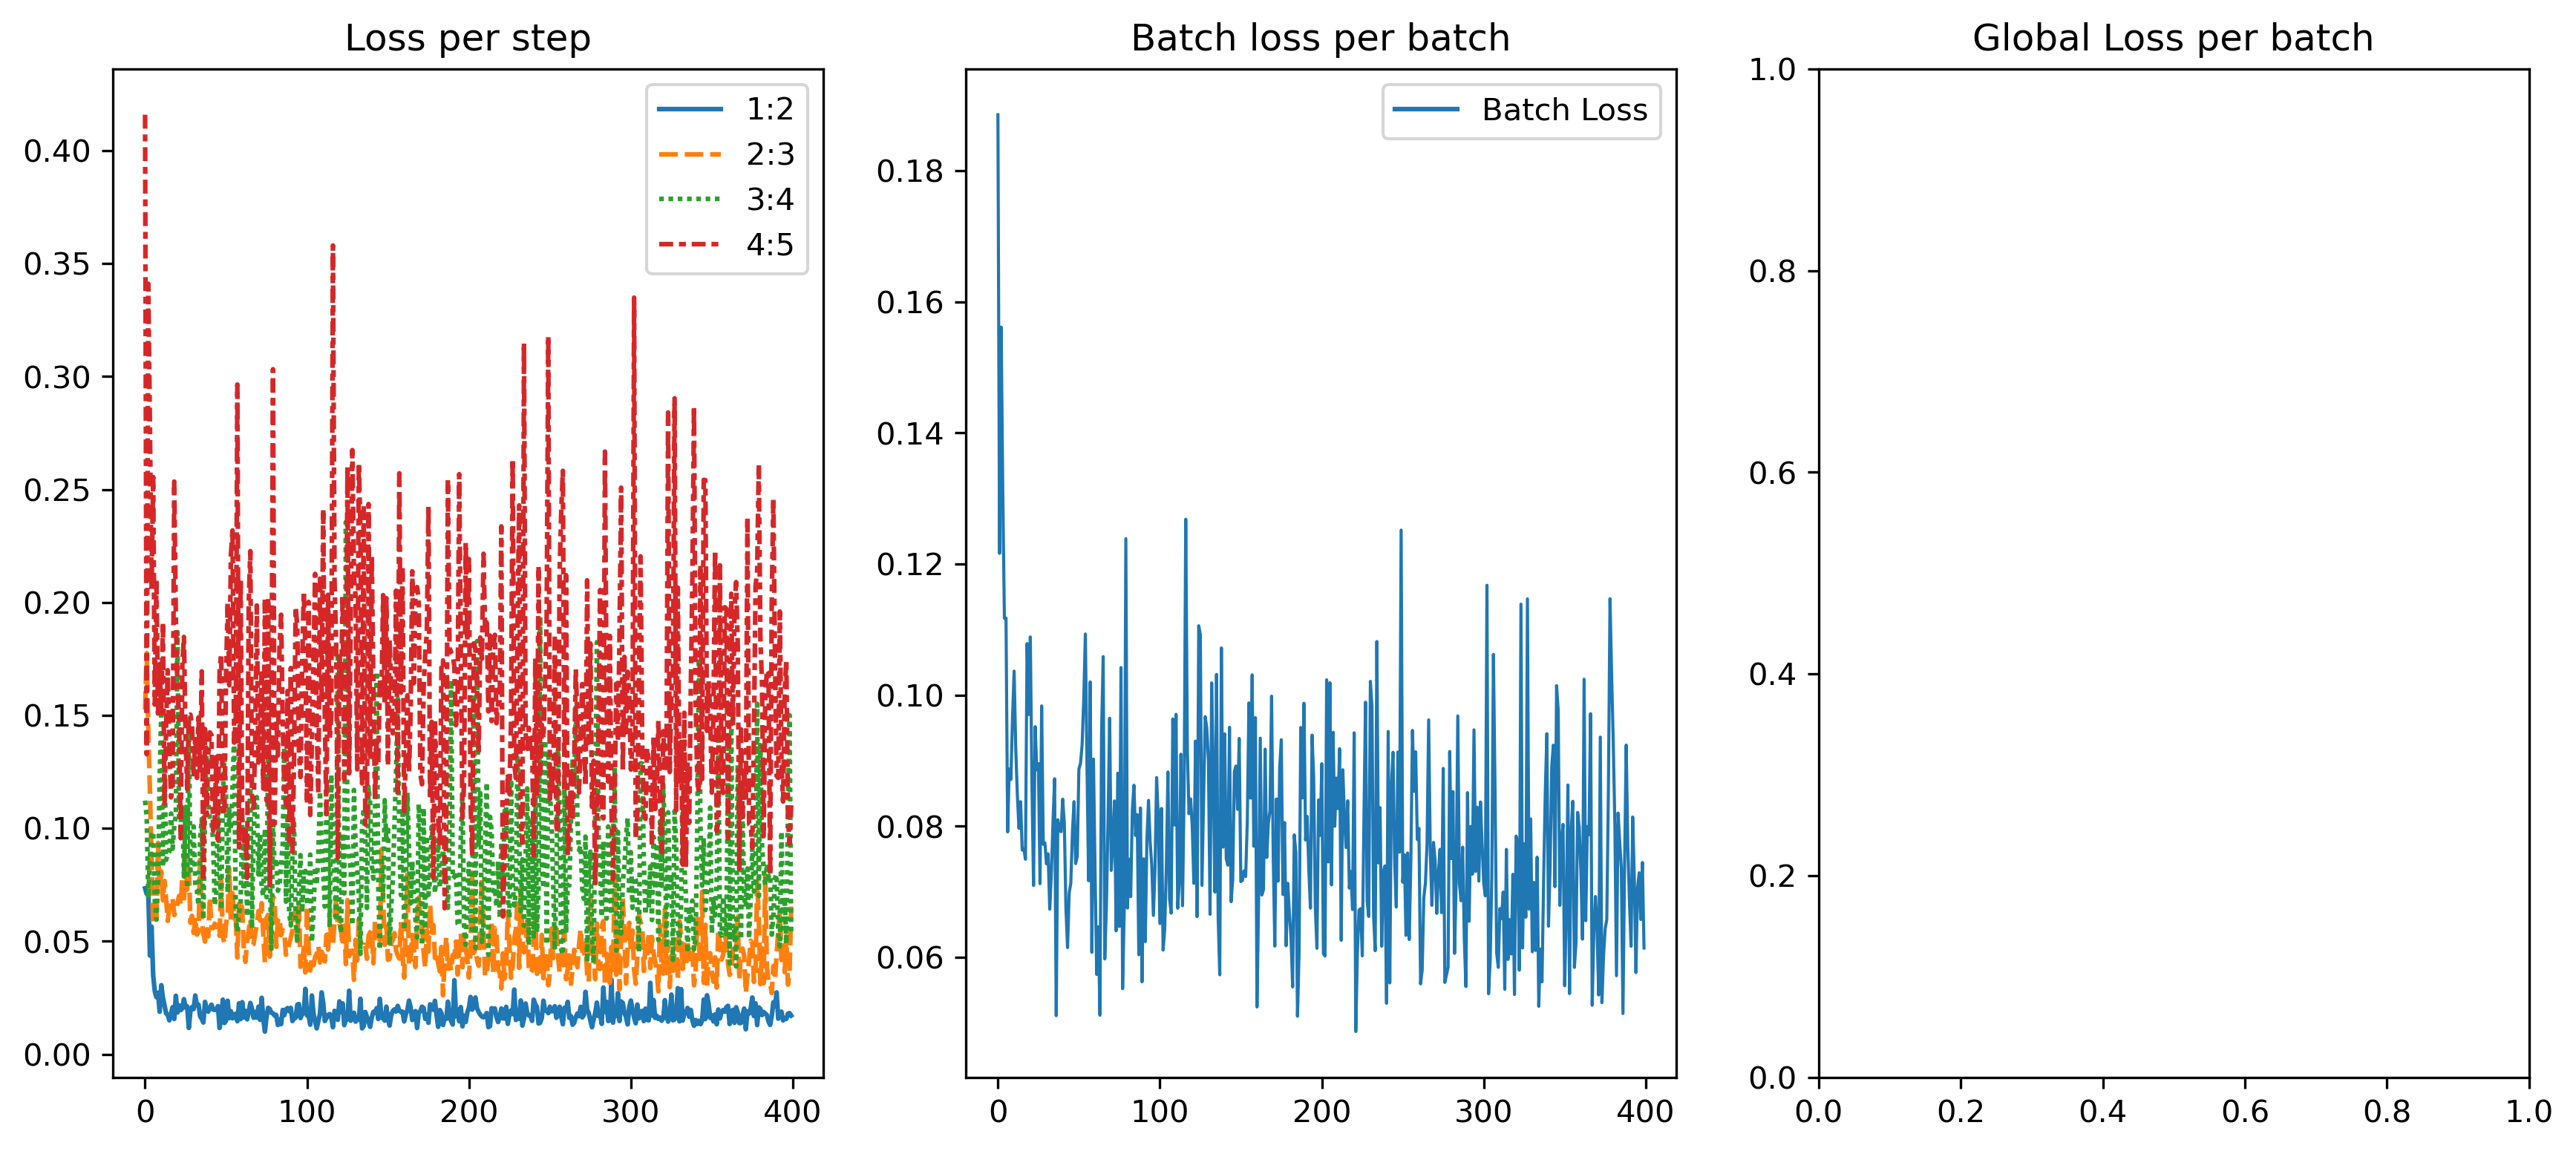

In [73]:
plot_losses(
    local_losses, batch_losses, globe_losses, 
    save=True, path=exp_dir, file='losses.png'
)

In [76]:
generated, trajectories = generate_plot_data(
    model, df, n_points, n_trajectories, n_bins=100, 
    sample_with_replacement=sample_with_replacement, use_cuda=use_cuda, samples_key='samples', autoencoder=autoencoder
)
if autoencoder is not None:
    if use_cuda:
        generated, trajectories = torch.Tensor(generated).cuda(), torch.Tensor(trajectories).cuda()
    else:
        generated, trajectories = torch.Tensor(generated), torch.Tensor(trajectories)
    generated, trajectories = autoencoder.decoder(generated).detach().cpu(), autoencoder.decoder(trajectories).detach().cpu() 

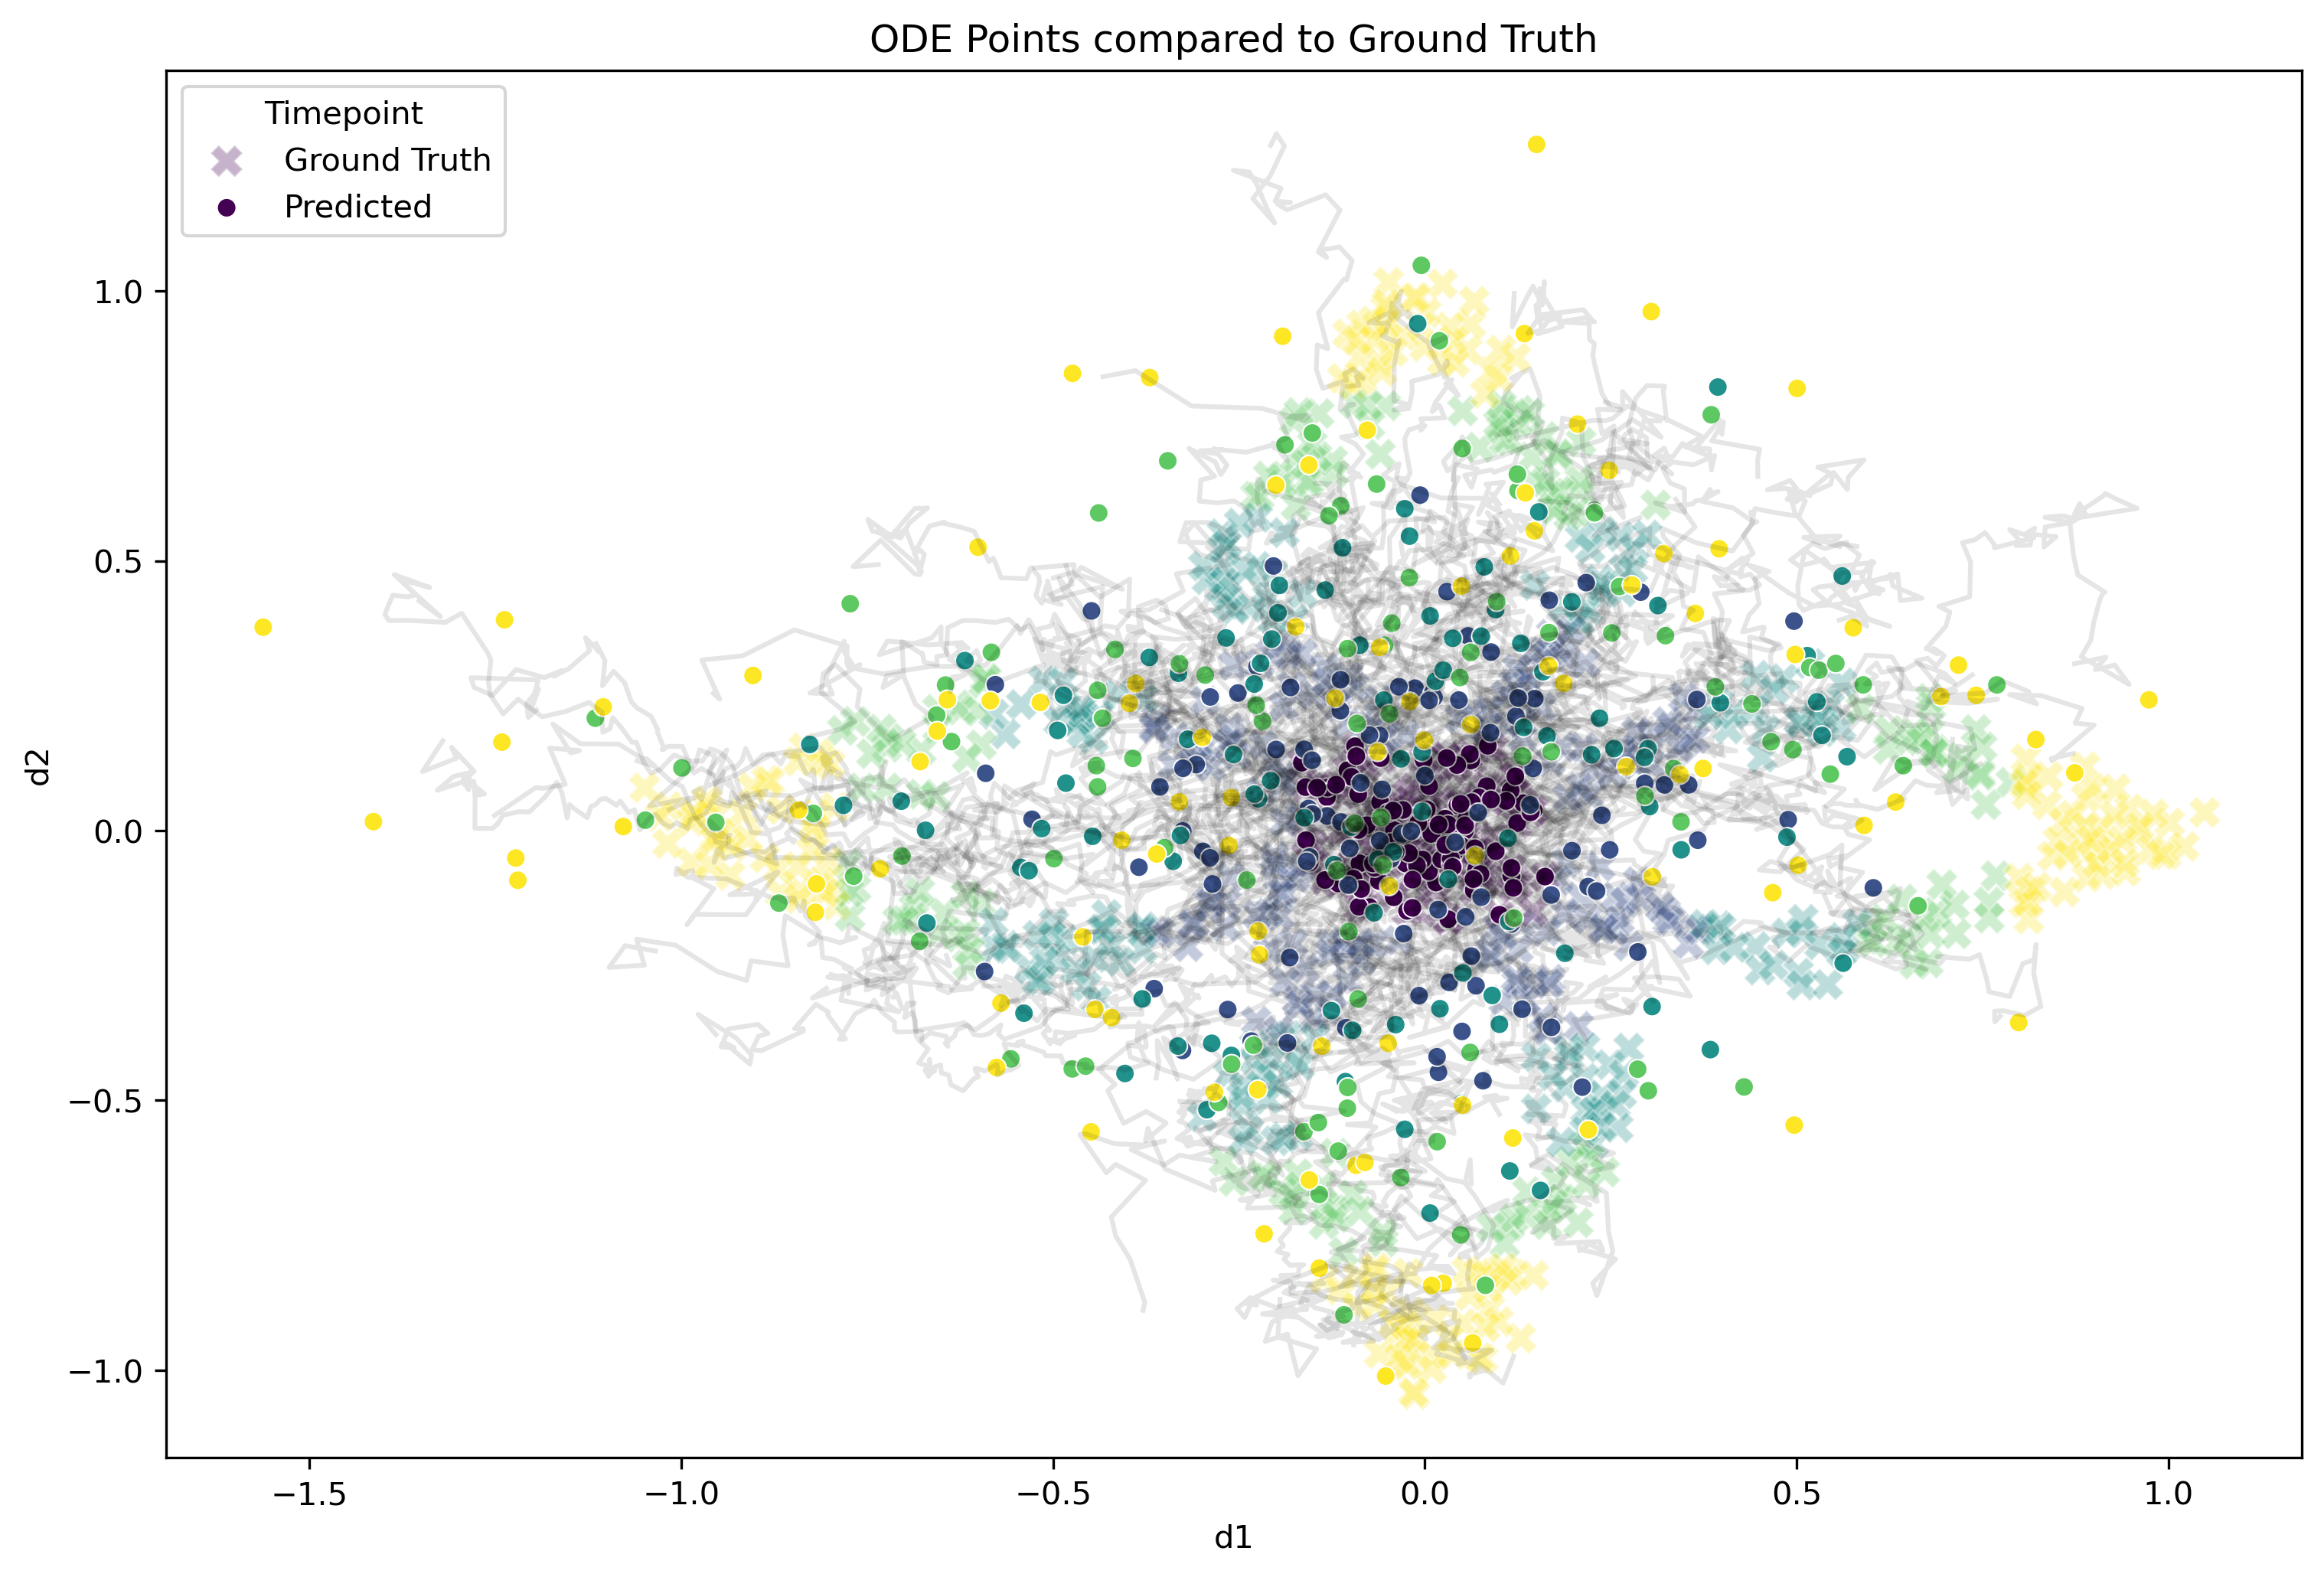

In [78]:
plot_comparision(
    df, generated, trajectories,
    palette = 'viridis', df_time_key='samples',
    save=True, path=exp_dir, file='2d_comparision.png',
    x='d1', y='d2', z='d3', is_3d=False
)